#<font color='lightblue'>Intro</font>
If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

The task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses.

[competition link](https://www.kaggle.com/competitions/contradictory-my-dear-watson/overview)

#<font color='lightblue'>Imports</font>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
#load data from drive
from google.colab import drive
#plots
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
#training plots
import matplotlib.pyplot as plt 
# nn, bert
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf



#<font color='lightblue'>Load data</font>

In [3]:
# from google.colab import files
# uploaded = files.upload()

drive.mount('/content/drive')
path = "/content/drive/MyDrive/git_projects/watson/train_watson.csv"
origin_train = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.set_option('display.max_rows', 6) #for all df: pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.options.display.max_colwidth = 200

display(origin_train)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulating the interim rules.,The rules developed in the interim were put together with these comments in mind.,en,English,0
1,5b72532a0b,"These are issues that we wrestle with in practice groups of law firms, she said.",Practice groups are not permitted to work on these issues.,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.,J'essayais d'accomplir quelque chose.,fr,French,0
...,...,...,...,...,...,...
12117,5085923e6c,The important thing is to realize that it's way past time to move it.,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the whole temple complex.,The model temple complex is at the east end.,en,English,2
12119,44301dfb14,"For himself he chose Atat??rk, or Father of the Turks.",Ataturk was the father of the Turkish nation.,en,English,0


#<font color='lightblue'>Data exploration</font>

In [5]:
print("df size ",origin_train.shape,"\n")
for column in origin_train:
    print("Na in column",column,origin_train[column].isna().sum())


df size  (12120, 6) 

Na in column id 0
Na in column premise 0
Na in column hypothesis 0
Na in column lang_abv 0
Na in column language 0
Na in column label 0


In [6]:
fig = px.pie(origin_train, names='label',color_discrete_sequence=[ 'mediumturquoise', 'paleturquoise','teal'],title='Target split')
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    autosize=False,
    width=350,
    height=350,
    paper_bgcolor="LightGrey",
)

fig.show()

In [7]:
fig = px.histogram(origin_train, x="language", color="label",title='Language and labels split',color_discrete_sequence=[ 'mediumturquoise', 'paleturquoise','teal'])


fig.show()

#<font color='lightblue'>Train model</font>

##<font color='lightblue'>Switch to TPU runtime</font>

In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

##<font color='lightblue'>Load pretrained model</font>

In [9]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

##<font color='lightblue'>Build model</font>

In [10]:
max_length=50

In [11]:
def encode_sentence(s,max_len):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   tokens_ids_list=tokenizer.convert_tokens_to_ids(tokens)
   if len(tokens_ids_list)>max_len:
     return tokens_ids_list[:max_len] #cut to max len
   else:
    return tokens_ids_list+[0] * (max_len - len(tokens_ids_list)) # pad to max len

In [12]:
def bert_encode(hypotheses, premises, tokenizer,max_len):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([encode_sentence(s,max_len) for s in np.array(hypotheses)]) #array to ragged tensor (different sizes)
  sentence2 = tf.ragged.constant([encode_sentence(s,max_len) for s in np.array(premises)])
  print(sentence1)
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] #sentence1.shape[0] number of rows
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) #all words ids of both sentances into 1 row
  input_mask = tf.ones_like(input_word_ids).to_tensor() #tensor of ones in the shape of input_word_ids
  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [13]:
train_input = bert_encode(origin_train.premise.values, origin_train.hypothesis.values, tokenizer,max_length)

<tf.RaggedTensor [[10111, 11762, 61565, ..., 0, 0, 0],
 [13252, 10301, 17850, ..., 0, 0, 0],
 [13810, 32181, 65533, ..., 0, 0, 0],
 ...,
 [10117, 12452, 40414, ..., 0, 0, 0],
 [11699, 10105, 13735, ..., 0, 0, 0],
 [11399, 14764, 10261, ..., 0, 0, 0]]>


In [14]:
def build_model(max_len = 50):
    bert_encoder = TFBertModel.from_pretrained(model_name) #using the pretrained model of bert
    input_word_ids = tf.keras.Input(shape=(((max_len*2)+1),), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(((max_len*2)+1),), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(((max_len*2)+1),), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    


    
    return model

In [15]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = build_model()
    model.summary()


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 101)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 101)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 101)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



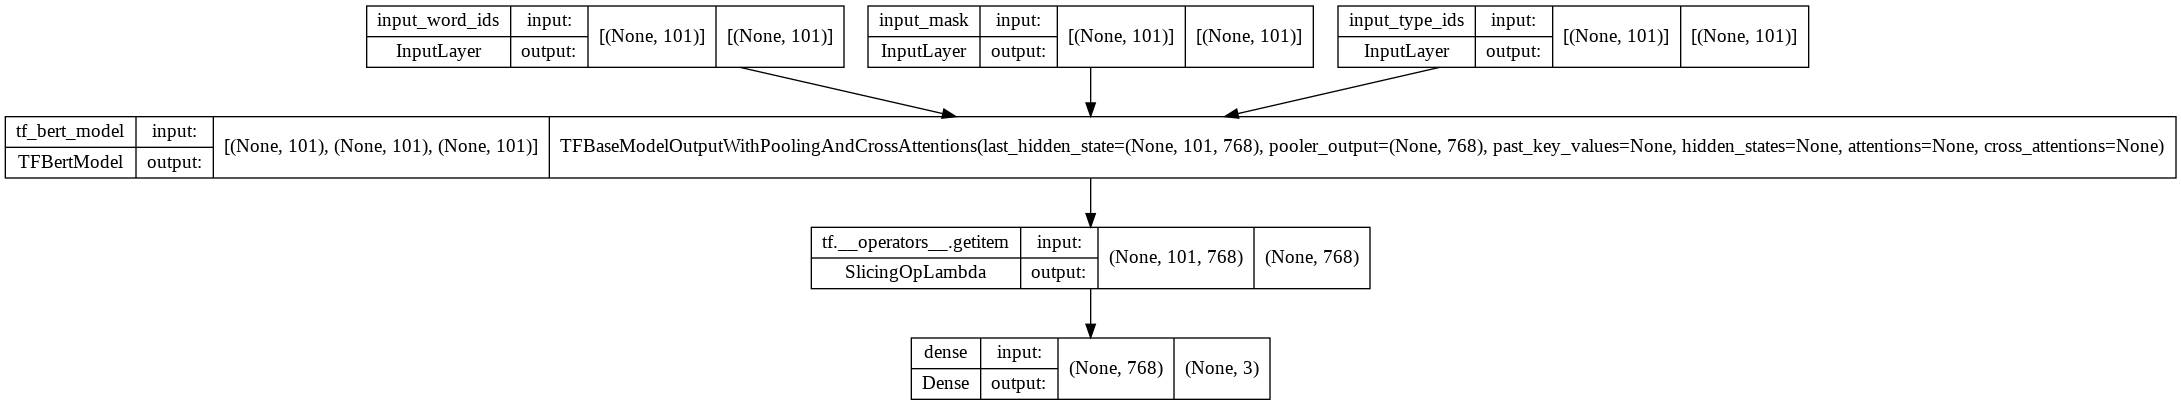

In [16]:
#present model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

##<font color='lightblue'>Fit model to train data</font>

In [17]:
#model hyper params
batch_size_for_train=512
num_epochs=8

In [18]:
history=model.fit(train_input, origin_train.label.values, epochs = num_epochs, verbose = 1,validation_split=0.25, batch_size = batch_size_for_train)

Epoch 1/8


18/18 [==============================] - 824s 45s/step - loss: 1.1142 - accuracy: 0.3606 - val_loss: 1.0678 - val_accuracy: 0.4472
Epoch 2/8
18/18 [==============================] - 801s 45s/step - loss: 1.0509 - accuracy: 0.4498 - val_loss: 0.9707 - val_accuracy: 0.5304
Epoch 3/8
18/18 [==============================] - 801s 45s/step - loss: 0.9372 - accuracy: 0.5649 - val_loss: 0.9147 - val_accuracy: 0.5855
Epoch 4/8
18/18 [==============================] - 803s 45s/step - loss: 0.8592 - accuracy: 0.6041 - val_loss: 0.8654 - val_accuracy: 0.6040
Epoch 5/8
18/18 [==============================] - 802s 45s/step - loss: 0.7919 - accuracy: 0.6504 - val_loss: 0.8570 - val_accuracy: 0.6152
Epoch 6/8
18/18 [==============================] - 803s 45s/step - loss: 0.7375 - accuracy: 0.6774 - val_loss: 0.8827 - val_accuracy: 0.6033
Epoch 7/8
18/18 [==============================] - 803s 45s/step - loss: 0.6871 - accuracy: 0.7100 - val_loss: 0.8461 - val_accuracy: 0.6244
Epoch 8/8
18/18 [======

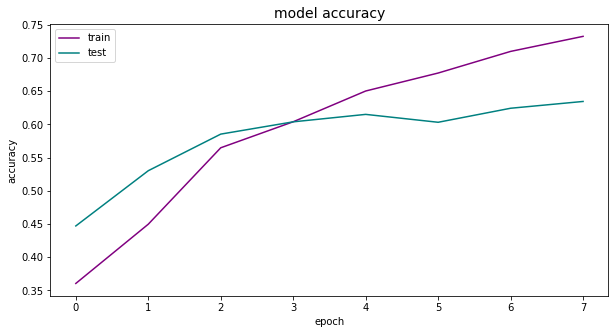

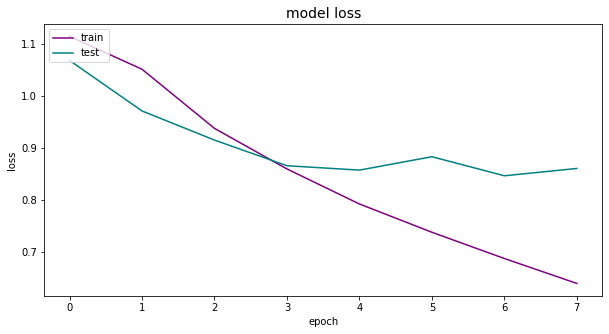

In [19]:
# summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],color='purple')
plt.plot(history.history['val_accuracy'],color='teal')
plt.title('model accuracy', fontsize=14)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],color='purple')
plt.plot(history.history['val_loss'],color='teal')
plt.title('model loss', fontsize=14)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### NOTE: results analysis

We can see around the 3d epoch we are begining the phase of over fitting (loss of train keeps dropping while validation loss is remaining almost stable) for production mode we'd rather to stop the training earlier (~3d epoch) so we can work with new examples as well. In this case I choose to experiment and see where I get the better accuracy results on validation set.

#<font color='lightblue'>Prediction</font>

##<font color='lightblue'>Load test data</font>

In [20]:
path = "/content/drive/MyDrive/git_projects/watson/test_watson.csv"
test = pd.read_csv(path)

##<font color='lightblue'>Predict test data</font>

In [21]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer,max_length)

<tf.RaggedTensor [[764, 28744, 752, ..., 12574, 11722, 11285],
 [13498, 11917, 12441, ..., 0, 0, 0],
 [10131, 24552, 10176, ..., 0, 0, 0],
 ...,
 [3239, 5755, 2568, ..., 0, 0, 0],
 [98370, 112, 188, ..., 0, 0, 0],
 [10167, 15078, 14577, ..., 0, 0, 0]]>


In [22]:
predictions = [np.argmax(i) for i in model.predict(test_input)] #prediction using the trained model

In [23]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
